In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches
import numpy as np
import matplotlib.pylab as plt
import random
from dataclasses import dataclass
import matplotlib.pyplot as plt

In [28]:
# Leer archivo txt de dos columnas: tiempo y porcentaje de conversión
archivo1 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina_C1.txt"
archivo2 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina_C2.txt"
archivo3 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina.txt"

data_txt1 = pd.read_csv(archivo1, sep="\s+", header=None, names=["Tiempo", "Porcentaje"])
data_txt2 = pd.read_csv(archivo2, sep="\s+", header=None, names=["Tiempo", "Porcentaje"])
data_txt3 = pd.read_csv(archivo3, sep="\s+", header=None, names=["Tiempo", "Porcentaje", "Error"])

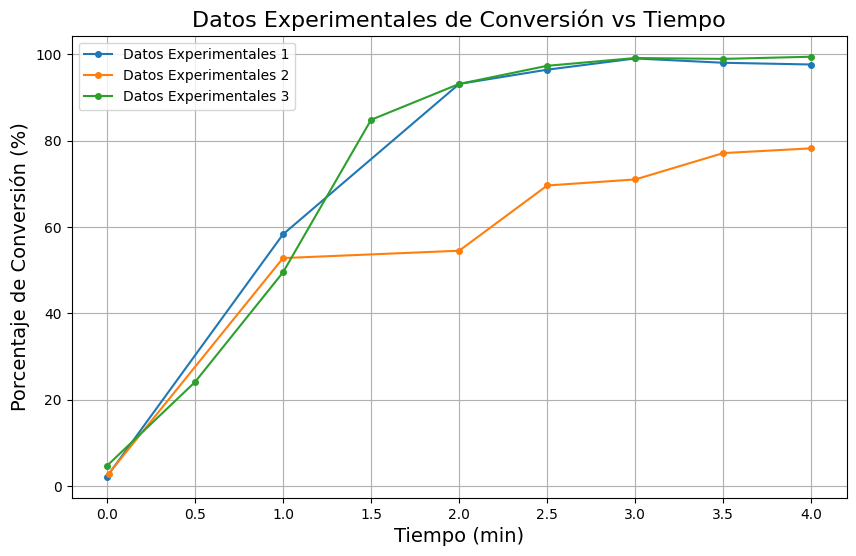

In [29]:
Experiments = [data_txt1, data_txt2, data_txt3]

plt.figure(figsize=(10, 6))
for i, exp in enumerate(Experiments, start=1):
    plt.plot(exp["Tiempo"], exp["Porcentaje"], '-o', label=f'Datos Experimentales {i}', markersize=4)
plt.xlabel('Tiempo (min)', fontsize=14)
plt.ylabel('Porcentaje de Conversión (%)', fontsize=14)
plt.title('Datos Experimentales de Conversión vs Tiempo', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [30]:
import numpy as np
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.signal import convolve2d

# -----------------------------
# Constantes de estados
# -----------------------------
EMPTY, HEMIN, STEP = 0, 1, 2
VECINOS = [(1,0), (-1,0), (0,1), (0,-1)]

# -----------------------------
# Utilidades
# -----------------------------
def arrhenius(nu0, Ea, T, kB):
    Ea_eff = max(0.0, Ea)
    return nu0 * np.exp(-Ea_eff / (kB * T))

# -----------------------------
# Parámetros del modelo
# -----------------------------
@dataclass
class Params2D:
    Lx: int = 60
    Ly: int = 60
    T: float = 298.15
    kB: float = 8.617e-5
    nu0: float = 1e8
    Ead: float = 0.25
    Ede: float = 0.45
    Eai: float = 0.0
    Eab: float = 0.48
    Eac: float = 0.3
    Jad: float = 0.008
    Jinc: float = 0.000
    Jdes: float = 0.008
    Jmove: float = 0.01
    mu: float = -0.10
    activity_hemin: float = 1.0
    face_bias: float = 1.0
    enable_ads: bool = True
    enable_des: bool = True
    enable_diff: bool = True
    enable_incorp: bool = True
    time_scale: float = 1.0  # ← Factor de conversión temporal (nuevo)

# -----------------------------
# Contador rápido de vecinos
# -----------------------------
def count_bonds_all(grid):
    kernel = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
    mask = (grid == HEMIN) | (grid == STEP)
    bonds = convolve2d(mask.astype(np.int8), kernel, mode='same', boundary='wrap')
    return bonds

# -----------------------------
# Núcleo KMC 2D Optimizado
# -----------------------------
class KMC2D:
    def __init__(self, p, seed=0):
        self.p = p
        self.grid = np.zeros((p.Lx, p.Ly), dtype=np.int8)
        self.rng = np.random.default_rng(seed)
        self.t = 0.0
        # Semilla inicial: una molécula de hemina en el centro
        self.grid[p.Lx//2, p.Ly//2] = HEMIN

        # Tasas base precomputadas
        self.k_ads0 = arrhenius(p.nu0, p.Ead - p.mu, p.T, p.kB)
        self.k_des0 = arrhenius(p.nu0, p.Ede, p.T, p.kB)
        self.k_diffb0 = arrhenius(p.nu0, p.Eab, p.T, p.kB)
        self.k_diffc0 = arrhenius(p.nu0, p.Eac, p.T, p.kB)
        self.k_incorp0 = arrhenius(p.nu0, p.Eai, p.T, p.kB)

    def local_rates(self, i, j, bonds):
        g, p = self.grid, self.p
        rates = {}

        if g[i,j] == EMPTY:
            if p.enable_ads:
                k = self.k_ads0 * np.exp(-bonds*p.Jad/(p.kB*p.T))
                if bonds > 0:
                    rates["ads"] = k * p.activity_hemin
            if p.enable_incorp and bonds > 0:
                k = self.k_incorp0 * np.exp(bonds*p.Jinc/(p.kB*p.T))
                rates["incorp"] = k * p.face_bias

        elif g[i,j] == HEMIN:
            if p.enable_des:
                k = self.k_des0 * np.exp(bonds*p.Jdes/(p.kB*p.T))
                rates["desorb"] = k
            if p.enable_diff:
                for dx, dy in VECINOS:
                    Ea_move = (p.Eab if dx else p.Eac) + bonds*p.Jmove
                    kdiff = arrhenius(p.nu0, Ea_move, p.T, p.kB)
                    x, y = (i+dx) % p.Lx, (j+dy) % p.Ly
                    if g[x, y] == EMPTY:
                        rates[("diff", dx, dy)] = kdiff
            if p.enable_incorp and bonds > 0:
                rates["lock"] = self.k_incorp0 * np.exp(bonds*p.Jinc/(p.kB*p.T)) * p.face_bias
        return rates

    def pick_event(self, bonds):
        Lx, Ly = self.grid.shape
        events, rates = [], []
        for i in range(Lx):
            for j in range(Ly):
                for kind, r in self.local_rates(i, j, bonds[i,j]).items():
                    events.append((kind, (i,j)))
                    rates.append(r)
        if not rates:
            return None, None, 0.0
        rates = np.array(rates)
        Rtot = rates.sum()
        cum = np.cumsum(rates)
        u = self.rng.random() * Rtot
        idx = np.searchsorted(cum, u)
        kind, ij = events[idx]
        return kind, ij, Rtot

    def do_event(self, kind, ij):
        i, j = ij
        g = self.grid
        if kind == "ads":
            g[i,j] = HEMIN
        elif kind == "incorp":
            g[i,j] = STEP
        elif kind == "desorb":
            g[i,j] = EMPTY
        elif kind == "lock":
            g[i,j] = STEP
        elif isinstance(kind, tuple) and kind[0] == "diff":
            dx, dy = kind[1:]
            x, y = (i+dx)%g.shape[0], (j+dy)%g.shape[1]
            if g[x,y] == EMPTY:
                g[i,j] = EMPTY
                g[x,y] = HEMIN

    def step(self):
        bonds = count_bonds_all(self.grid)
        kind, ij, Rtot = self.pick_event(bonds)
        if kind is None:
            return False
        self.do_event(kind, ij)
        dt = -np.log(max(self.rng.random(), 1e-16)) / Rtot
        self.t += dt * self.p.time_scale  # ← Se aplica la escala temporal aquí
        return True

    def run_until(self, tmax=10.0, snapshot_every=1.0, store_snapshots=False):
        times, covers, snaps = [], [], []
        next_snap = snapshot_every
        while self.t < tmax:
            if not self.step():
                break
            occ = np.count_nonzero(self.grid > 0) / self.grid.size
            times.append(self.t)
            covers.append(occ)
            if store_snapshots and self.t >= next_snap:
                snaps.append((self.t, np.copy(self.grid)))
                next_snap += snapshot_every
        if store_snapshots:
            return np.array(times), np.array(covers), snaps
        return np.array(times), np.array(covers), np.copy(self.grid)




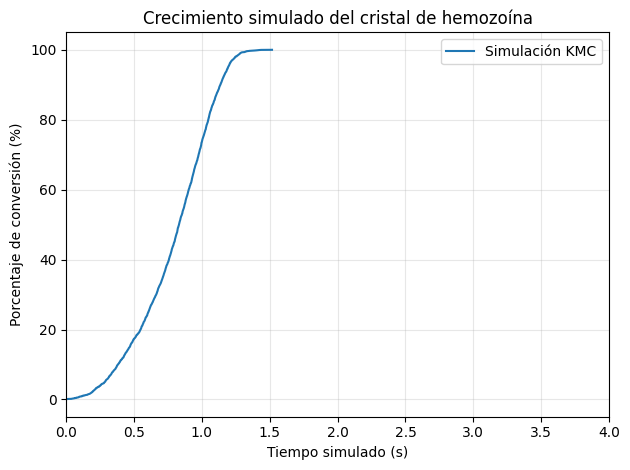

In [40]:
# -----------------------------
# Ejemplo de ejecución y gráfica
# -----------------------------
p = Params2D(
    Ead=0.1, Ede=0.1, Eai=0.0,
    Eab=0.48, Eac=0.3,
    Jad=0.008, Jinc=0.000, Jdes=0.008, Jmove=0.01,
    mu=-0.070,
    time_scale=0.6e7   # ← Escala temporal
)

sim = KMC2D(p, seed=1)
times, covers, snaps = sim.run_until(tmax=5.0, snapshot_every=1.0, store_snapshots=True)

# Conversión en porcentaje
conversion = covers * 100


# plt.plot(Experiments[2]['Tiempo'], Experiments[2]['Porcentaje'], label='Datos Experimentales')
plt.plot(times, conversion, label='Simulación KMC')
plt.xlabel('Tiempo simulado (s)')
plt.ylabel('Porcentaje de conversión (%)')
plt.title('Crecimiento simulado del cristal de hemozoína')
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0,4)
plt.tight_layout()
plt.show()

In [8]:
p_fast = Params2D(
    Ead=0.25, Ede=0.60, Eai=0.0,
    Eab=0.28, Eac=0.20,
    Jad=0.002, Jinc=0.02, Jdes=0.004, Jmove=0.003,
    mu=+0.12,
    face_bias=3.0,
    activity_hemin=1.0,
    nu0=1e9
)
sim = KMC2D(p_fast, seed=1)
t_fast, cov_fast, _ = sim.run_until(tmax=5.0, snapshot_every=1.0, store_snapshots=True)


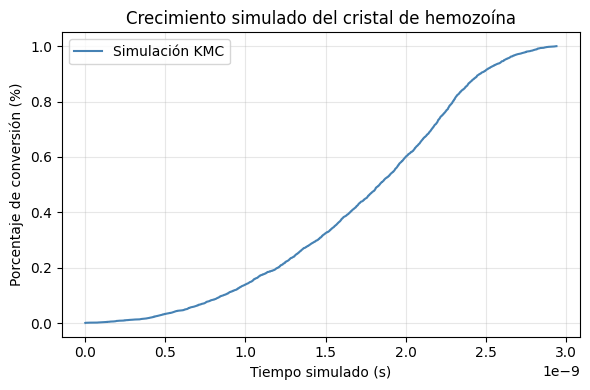

In [11]:
conversion = covers * 100

# ----------------------------
# Gráfico cinético
# ----------------------------
plt.figure(figsize=(6,4))
plt.plot(t_fast, cov_fast, color='steelblue', label='Simulación KMC')
plt.xlabel('Tiempo simulado (s)')
plt.ylabel('Porcentaje de conversión (%)')
plt.title('Crecimiento simulado del cristal de hemozoína')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()